# Compatability with transitleastsquares
The transitleastsquares module (Michael Hippke & René Heller 2019) can be called as an option through the BLS functionality. The transitleastsquares module has been configured to use the same input object as BLS, and additional parameters can be specified through the pars attribute. Note that these will override the default fixing of the duration grid.

In [14]:
import os
import numpy as np
import pandas as pd
homedir = os.getcwd()
import pytfit5.bls_cpu as gbls
import pytfit5.transitPy5 as tpy5
from pytfit5.synthetic import generate_synthetic_lightcurve

## Searching the Synthetic Light-Curve
TLS is called with the tls function rather than the bls_pulse function. The synthetic light curve uses parameters very similar to the pytfit5_example notebook; the period, T0, snr and depth are occasionally modified to highlight a specific goal/purpose, which wil be discussed. 

## Considerations for transitleastsquares
Because TLS does not use phase-binning, it requires the errors of the flux in order to best fit the data. By adding the error as weights, TLS can now successfully detect the transits. It is also not configured to detect a singular transit or a pulse.

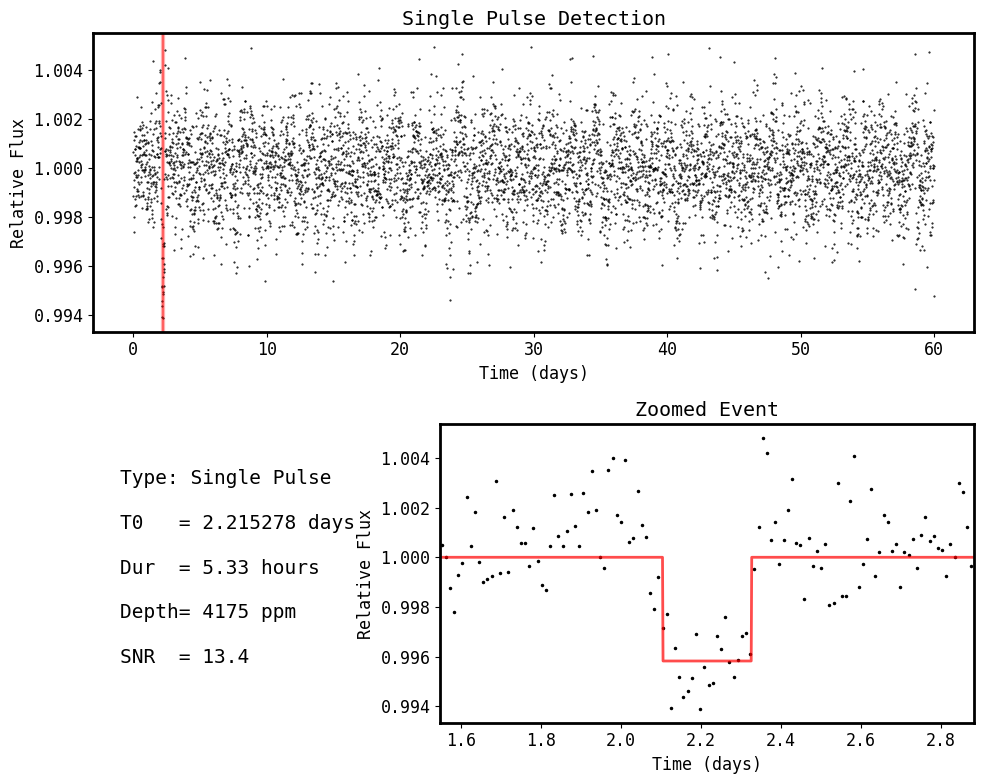

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 48 durations
Searching 5760 data points, 6636 periods from 0.601 to 59.99 days
Using all 20 CPU threads


100%|██████████| 6636/6636 periods | 00:12<00:00


{'M_star': np.float64(1.0),
 'M_star_max': np.float64(1.2),
 'M_star_min': np.float64(0.19999999999999996),
 'R_star': np.float64(1.0),
 'R_star_max': np.float64(1.2),
 'R_star_min': np.float64(0.19999999999999996),
 'n_transits_min': 1,
 'period_min': 0.5,
 'u': [0.4804, 0.1867]}


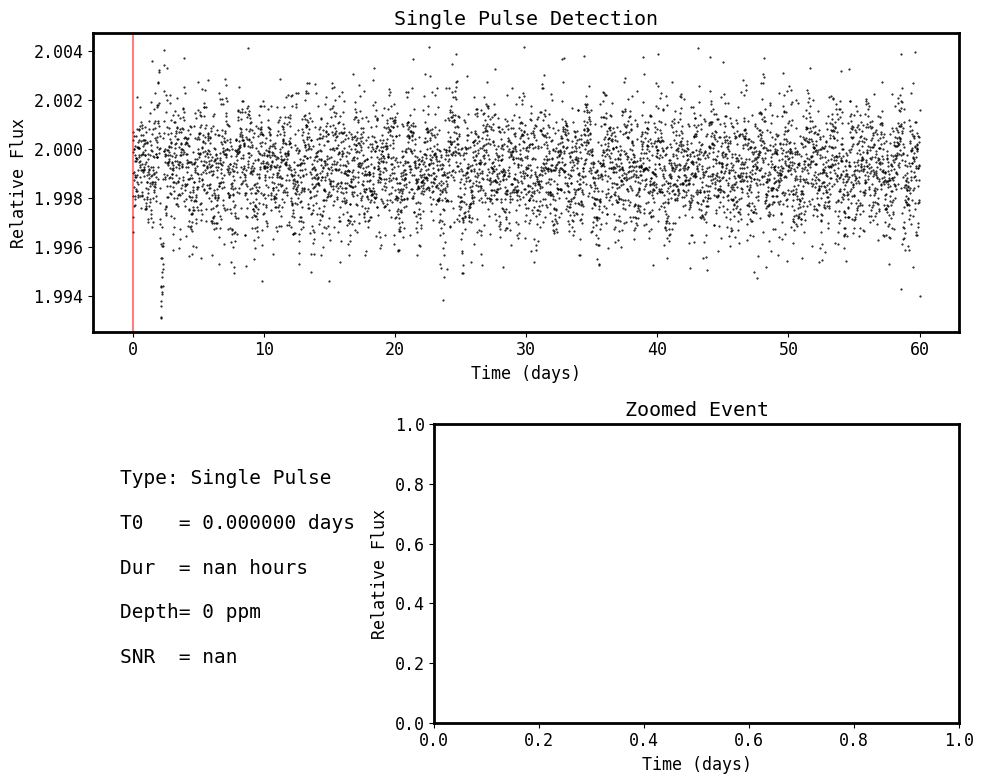

In [3]:
# Only the period is changed from the pytfit5 notebook - 10 days longer.
phot_syn, sol_injected = generate_synthetic_lightcurve(
    t0=2.2, per=66.05, time_length=60.0, depth=0.005, \
    snr=20.0, cadence=1.0/96.0, stellar_noise_type='multi', \
    stellar_noise_amplitude=0.005, rotation_period=None, seed=42)

# Configuring BLS and TLS for the synthetic data
# Removing those which are set by default appropriately, e.g zerotime, stellar parameters, etc.
syn_inputs = tpy5.tpy5_inputs_class()
syn_inputs.freq1 = 1.0 / (np.max(phot_syn.time) - np.min(phot_syn.time))  # longest period = baseline
syn_inputs.freq2 = 2.0  # c/d
syn_inputs.filename = "BLS_Synthetic"
# Data-processing is changed to 3 days detrending instead of the usual two.
syn_inputs.boxbin = 3.0  # set detrending length
syn_inputs.search_verbose  = True # for tls to spit out its parameters and search info
tpy5.run_polyfilter_iterative(phot_syn, syn_inputs)   # flux_f will contain filtered photometry

# Run Combined BLS + Pulse Search
bsyn = gbls.bls_pulse(syn_inputs, phot_syn.time, phot_syn.flux_f)
# Run TLS for a comparison to BLS
tsyn = gbls.tls(syn_inputs, phot_syn.time, phot_syn.flux_f)

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 48 durations
Searching 5760 data points, 6636 periods from 0.601 to 59.99 days
Using all 20 CPU threads


100%|██████████| 6636/6636 periods | 00:12<00:00


Searching for best T0 for period 16.04429 days


100%|██████████| 5760/5760 [00:00<00:00, 6557.70it/s]


{'M_star': np.float64(1.0),
 'M_star_max': np.float64(1.2),
 'M_star_min': np.float64(0.19999999999999996),
 'R_star': np.float64(1.0),
 'R_star_max': np.float64(1.2),
 'R_star_min': np.float64(0.19999999999999996),
 'n_transits_min': 1,
 'period_min': 0.5,
 'u': [0.4804, 0.1867]}


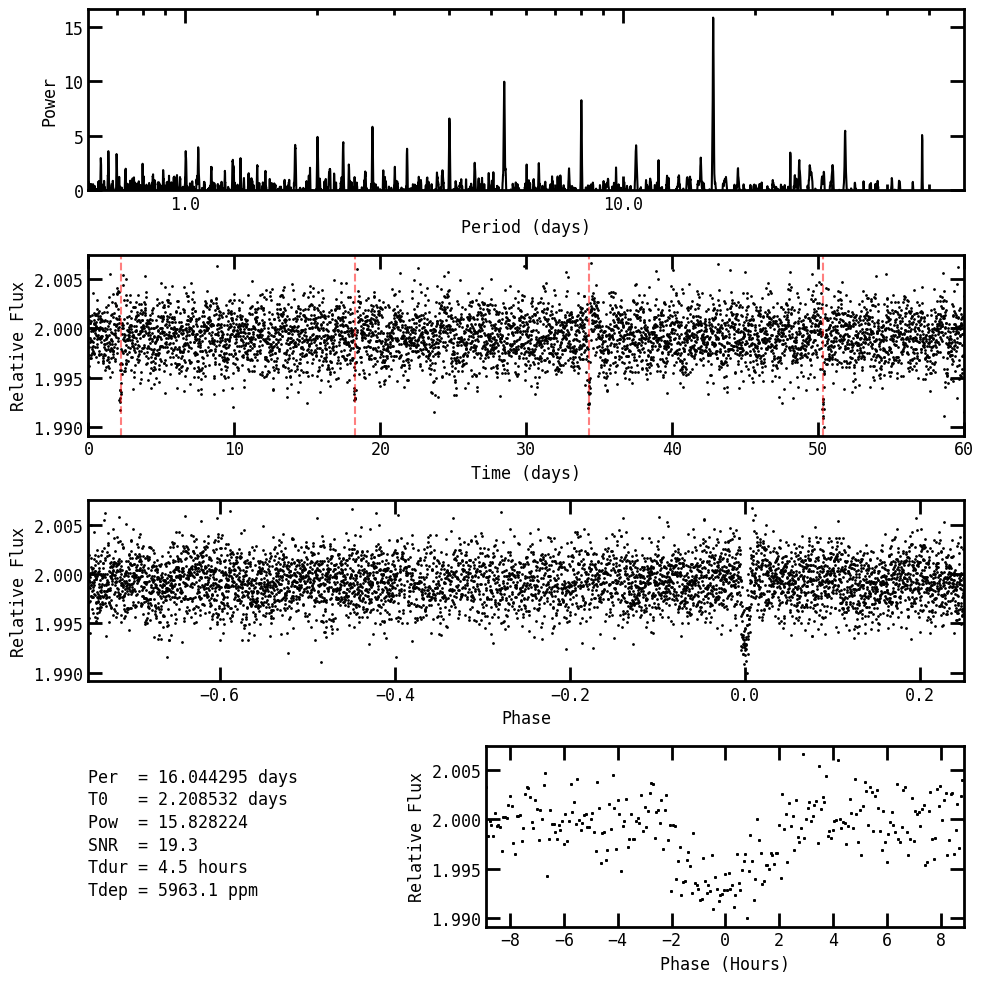

In [5]:
# Changing the period to shorter for easier detection by TLS.
phot_syn, sol_injected = generate_synthetic_lightcurve(
    t0=2.2, per=16.05, time_length=60.0, depth=0.005, \
    snr=20.0, cadence=1.0/96.0, stellar_noise_type='multi', \
    stellar_noise_amplitude=0.005, rotation_period=None, seed=42)
tpy5.run_polyfilter_iterative(phot_syn, syn_inputs)
tsyn = gbls.tls(syn_inputs, phot_syn.time, phot_syn.flux_f, phot_syn.ferr)

## Using the Roman Simulated Light-curves with Stellar Parameters
Because we have specified stellar parameters and limb-darkening from these simulated light-curves, this offers a useful measure to assess the performance of `transitleastsquares`! To do so, we call pipeline functions in `pipefuncs.py`, which offer us an easy way to access these light-curves.

In [4]:
f'{pipe.LCDIR}/{int(ric)}raw.h5'

'/home/sliu/bls_cuda/data/rlc/121833raw.h5'

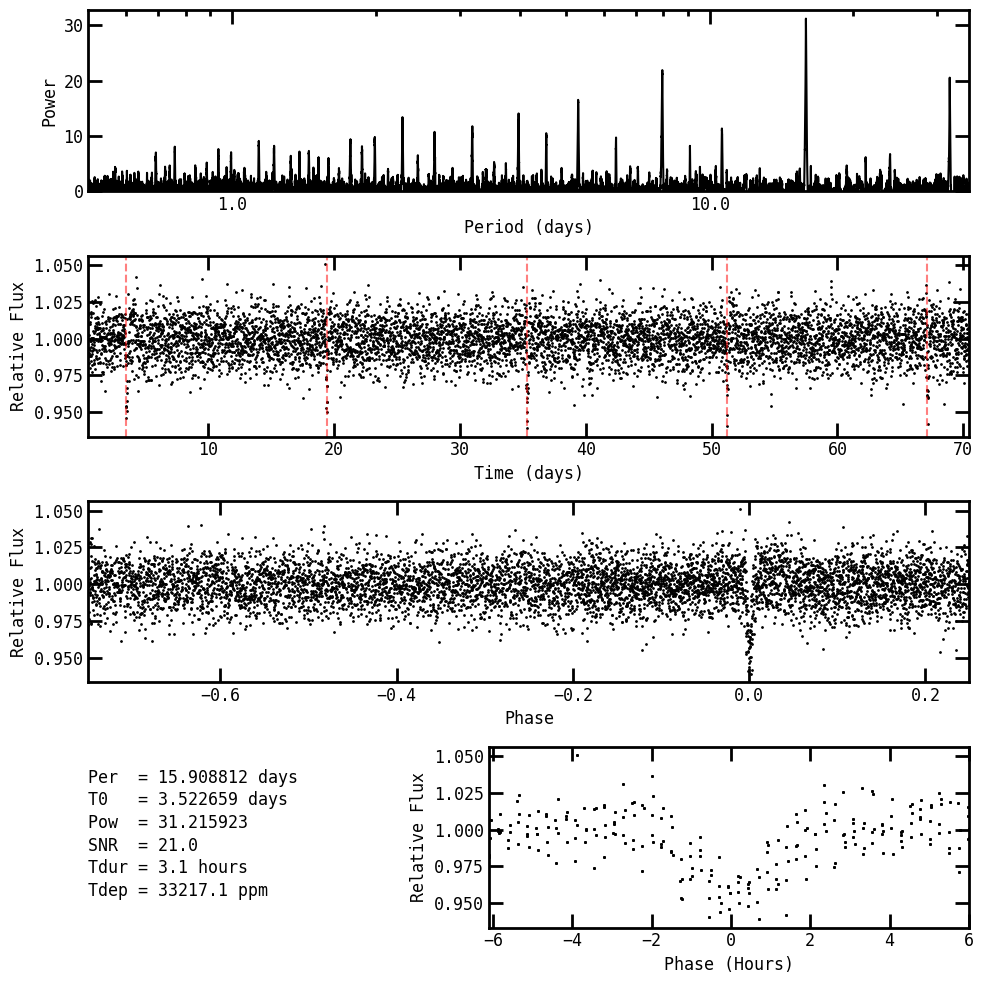

100%|██████████| 12030/12030 periods | 00:23<00:00
100%|██████████| 6595/6595 [00:01<00:00, 5305.71it/s]


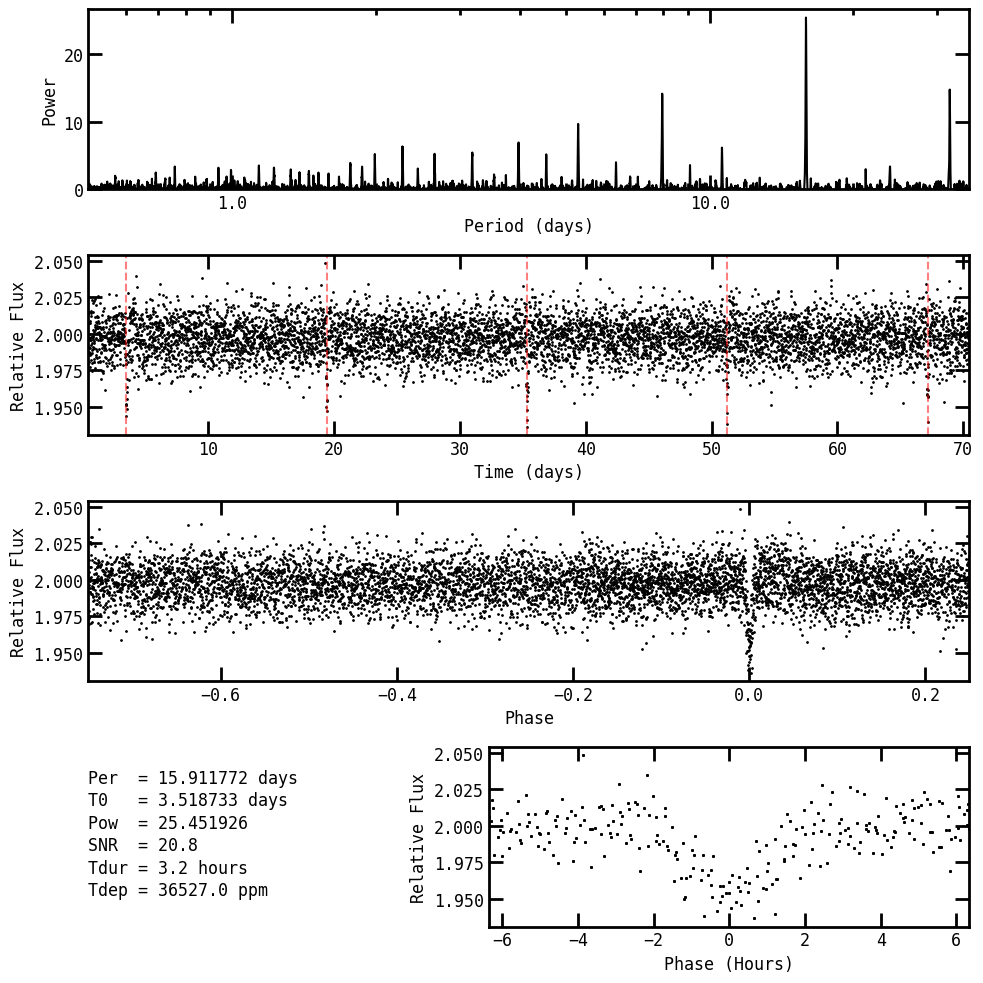

In [15]:
import pytfit5.pipefuncs as pipe

def runinstance(ric):
    '''
    To run a single occurrence, i.e. to run a single RIC.
    '''
    # Creating our input class and loading photometric data.
    roput = tpy5.tpy5_inputs_class()
    roput.zerotime = pipe.ROMANOFF
    phot = pipe.read2Phot(f'{pipe.LCDIR}/{int(ric)}raw.h5')
    ## Data Processing
    roput.boxbin, roput.dsigclip = 3.0, 0
    m = pipe.processData(phot, roput) # detrending/clipping
    t, f, err = phot.time[m], phot.flux_f[m], phot.ferr[m]
    
    ## Fetching the Stellar Parameters!
    starRow = pipe.getRICRow(ric, pipe.cat)
    roput.rstar = float(starRow['star_radius'])
    roput.mstar = float(starRow['star_mass'])
    roput.u = starRow[['transit_limb1_F146', 'transit_limb2_F146']].values
    
    brom = gbls.bls_pulse(roput, phot.time, phot.flux_f)
    trom = gbls.tls(roput, phot.time, phot.flux_f, phot.ferr)

runinstance(121833)

## Pipeline Functionality
For the Roman simulated lightcurves (in `/data/rlc`), we want to be able to iterate through them and save the outputs in order to consider the efficiency of `transitleastsquares` versus `bls_pulse`. What the pipeline must consider:
- Iterating through various RICs (the Roman Input Catalogue) and reading in their stellar parameters.
- Multiple transiting planets: we "swiss-cheese" to remove the transiting planets detected.
- Writing and saving the data to a dataframe for various output columns.

In [8]:
roput = tpy5.tpy5_inputs_class()
roput.zerotime = pipe.ROMANOFF
roput.plots = 0
roput.boxbin, roput.dsigclip = 3.0, 0
roput.filename = 'demo'
pipe.main(roput, pipe.starID[:5], pipe.cat)

Starting RIC: 848528, which is number: 0!


100%|██████████| 3775/3775 periods | 00:08<00:00
100%|██████████| 6595/6595 [00:01<00:00, 5532.52it/s]
100%|██████████| 3775/3775 periods | 00:11<00:00
100%|██████████| 6480/6480 [00:01<00:00, 5604.55it/s]


Starting RIC: 2823, which is number: 1!


100%|██████████| 20245/20245 periods | 00:40<00:00


Starting RIC: 4741250, which is number: 2!


100%|██████████| 9775/9775 periods | 00:21<00:00
100%|██████████| 9775/9775 periods | 00:20<00:00
100%|██████████| 6242/6242 [00:03<00:00, 1858.84it/s]
/home/sliu/tls_env/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sliu/tls_env/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/sliu/tls_env/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/sliu/bls_cuda/pytfit5/transitleastsquares/main.py:411: UserWarning: 114 of 136 transits without data. The true period may be twice the given period.
  warnings.warn(text)


Starting RIC: 4822853, which is number: 3!


100%|██████████| 9127/9127 periods | 00:20<00:00
100%|██████████| 6595/6595 [00:01<00:00, 5979.72it/s]
100%|██████████| 9127/9127 periods | 00:20<00:00
100%|██████████| 6560/6560 [00:01<00:00, 4371.29it/s]


Starting RIC: 375387, which is number: 4!


100%|██████████| 10997/10997 periods | 00:28<00:00
100%|██████████| 6595/6595 [00:01<00:00, 5043.46it/s]
100%|██████████| 10997/10997 periods | 00:26<00:00
100%|██████████| 6505/6505 [00:01<00:00, 5799.75it/s]
100%|██████████| 10997/10997 periods | 00:27<00:00
100%|██████████| 6217/6217 [00:01<00:00, 3789.40it/s]
100%|██████████| 10997/10997 periods | 00:28<00:00
100%|██████████| 6289/6289 [00:01<00:00, 3215.29it/s]


Finished! Saving (just in case) again.


In [31]:
bdf = pd.read_csv(f'{pipe.SAVEDIR}/{roput.filename}bls0.csv')
tdf = pd.read_csv(f'{pipe.SAVEDIR}/{roput.filename}tls0.csv')
tdf

,RIC,Period,T0,TDur,TDepth,RawPer,SR,Power,SNR,Time
0,848528.0,14.160708,10.853151,0.194559,0.011702,14.160708,0.0,20.551920,13.719136,10.178566
1,848528.0,14.818067,3.329117,0.118700,0.005508,14.818067,0.0,6.265056,5.154414,12.988530
2,2823.0,0.630419,0.921423,0.027505,0.003192,0.630419,0.0,7.240404,5.491497,41.924288
3,4741250.0,1.032027,0.843045,0.044898,0.062876,1.032027,0.0,57.661539,157.954310,22.673618
4,4741250.0,0.515987,0.815646,0.001961,0.002103,12.366053,0.0,6.607052,5.494600,24.672482
5,4822853.0,24.455169,3.173958,0.093928,0.011283,32.793388,0.0,6.644533,7.754112,21.607696
6,4822853.0,5.452705,5.737374,0.045517,0.005634,5.452705,0.0,6.169923,5.074597,21.902313
7,375387.0,14.387431,4.028113,0.146175,0.021520,33.349168,0.0,7.962696,12.092100,29.785874
8,375387.0,20.478120,16.866108,0.290763,0.020876,20.478120,0.0,7.009896,11.387928,27.981174
9,375387.0,12.503037,11.442154,0.207816,0.015587,12.503037,0.0,6.392143,9.471013,28.991348


In [ ]:
# Testing the different BLS normalisations because I did edit it a tad...
roput.oneoverf_correction = False
roput.normalize = "none"
braw = gbls.bls_pulse(roput, phot.time, phot.flux_f)

roput.oneoverf_correction = True
roput.normalize = "none"
bcorrect = gbls.bls_pulse(roput, phot.time, phot.flux_f)

roput.normalize = "percentile_mad"
bperc = gbls.bls_pulse(roput, phot.time, phot.flux_f)